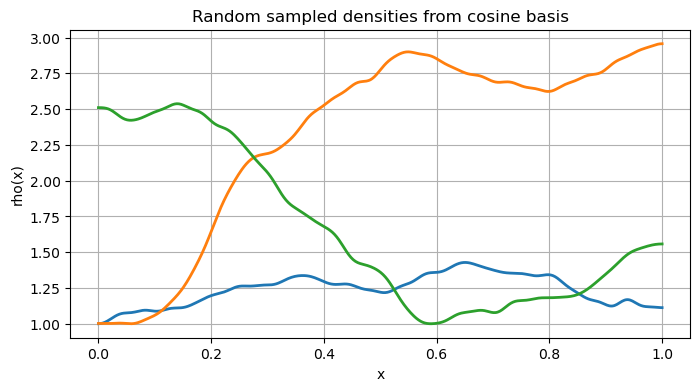

tensor([2.7889, 8.1050, 4.7126, 4.2253, 5.4247, 4.7308, 3.4472, 6.3121, 5.8720,
        6.3435, 4.3430, 4.9288, 4.6995, 2.7789, 3.5267, 5.7616, 2.5440, 3.4375,
        3.5666, 2.7380, 5.6173, 4.0806, 3.5661, 3.5050, 4.9126, 3.7464, 4.2873,
        2.5207, 3.9524, 4.1291, 3.4831, 8.0548])

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float32
device = "cpu"

M_cutoff = 50 # maximum harmonic
N_grid   = 512
m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
#design matrix needed to sample densities
DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
std_harm = 2.0 / (1.0 + m)**2

N_train = 1000
N_test = 200

N_batch = 32
N_epochs = 200
lr = 1e-3

def sample_density(*, rho_b=1.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density is non-negative everywhere

    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix                            

    rho = rho - rho.min() + rho_b                           # make non-negative
    return rho

def sample_density_batch(B: int, rho_b=1.0):
    """
    Sample a batch of B density profiles.
    Returns rho: (B, N_grid)
    """
    a = torch.normal(torch.zeros(B, std_harm.numel()), std_harm.expand(B, -1))
    rho = a @ DesignMatrix    # (B, N_grid)

    rho_min = rho.min(dim=1, keepdim=True).values
    rho = rho - rho_min + rho_b
    return rho

def E_tot(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute E_tot -- custom functional
    rho: (N,) or (B, N)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return (rho + rho**2).sum(dim=-1) / N_grid

# generate one sample
rho_batch = sample_density_batch(32)  # (B, N_grid)

# plot
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()


E_tot(rho_batch)  # (B,)


In [69]:
# we save features as (B, N_grid, N_feat), where N_feat=1 for now
# generate train/test split
rho_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test  = sample_density_batch(N_test)   # (N_test, N_grid)
features_train = rho_train.unsqueeze(-1)
features_test = rho_test.unsqueeze(-1)
targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,) 

# Normalize features per sample (to preserve relative spatial structure)
features_mean = features_train.mean(dim=(0, 1), keepdim=True)  # (1, 1, N_feat)
features_std = features_train.std(dim=(0, 1), keepdim=True) + 1e-8

# features_train_norm = (features_train - features_mean) / features_std
# features_test_norm = (features_test - features_mean) / features_std

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std() + 1e-8
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std

In [70]:
# Define the neural network models
class LocalEngDensityNN(nn.Module):
    """
    A neural network for predicting energy density from a local feature vector.
    """
    def __init__(self, N_feat=1, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N_feat, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1) # output is a scalar energy density
        )
    
    def forward(self, features):
        # features: (B, N_grid, N_feat)
        output = self.net(features)
        return output.squeeze(-1)
    
class TotalEnergyNN(nn.Module):
    def __init__(self, N_feat=1, hidden_dim=128):
        super().__init__()
        self.local_energy_net = LocalEngDensityNN(N_feat, hidden_dim)
        
    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat)
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        local_energies = self.local_energy_net(features)        # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,)
        
        return local_energies, total_energy

In [ ]:
#model training

model = TotalEnergyNN(N_feat=1)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_dataset = TensorDataset(features_train, targets_train_norm)
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True)

# Training loop
for epoch in range(N_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()

        local_pred, total_pred = model(batch_features)
        loss = criterion(total_pred, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}")


Epoch 10, Loss: 0.004160
Epoch 20, Loss: 0.001927
Epoch 30, Loss: 0.000741
Epoch 40, Loss: 0.000177
Epoch 50, Loss: 0.000119
Epoch 60, Loss: 0.000147


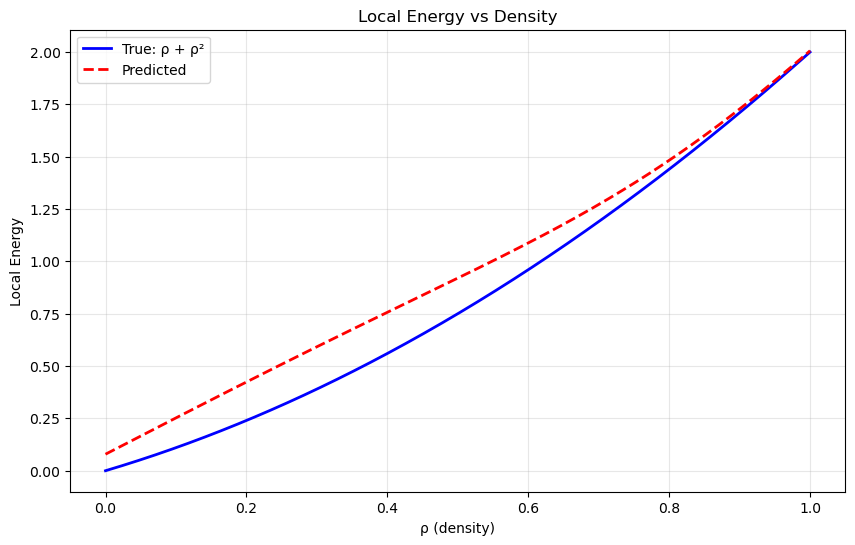

In [ ]:
rho_test = x.unsqueeze(-1).unsqueeze(0)  # (1, N_grid, 1)
loc_energy_dens = rho_test + rho_test**2


# local_pred, total_pred = model((rho_test - features_mean) / features_std)
local_pred, total_pred = model(rho_test)

# Plotting
rho_values = rho_test.squeeze().detach().numpy()  # (N_grid,)
true_local = loc_energy_dens.squeeze().detach().numpy()  # (N_grid,)
pred_local = local_pred.squeeze().detach().numpy()  # (N_grid,)

plt.figure(figsize=(10, 6))
plt.plot(rho_values, true_local, 'b-', linewidth=2, label='True: ρ + ρ²')
plt.plot(rho_values, pred_local * E_std.item() + E_mean.item(), 'r--', linewidth=2, label='Predicted')
plt.xlabel('ρ (density)')
plt.ylabel('Local Energy')
plt.title('Local Energy vs Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
pred_local
E_std

tensor(1.5224)